In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import calendar
import itertools

pd.set_option('display.max_columns', 50)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

sns.set_theme(style='darkgrid')

In [2]:
from models import MLP, ConvNet, LSTM
from train_test import train, test, output_to_accu, output_to_loss
from helpers import RSI, pred_to_perf, perf_to_stat, performance_plot, \
                    turnover, annual_alpha_plot_grossnet, annual_alpha_plot, correlation, \
                    pred_to_daily_ret, price_to_perf

# Data

In [3]:
indices_price_excel = pd.read_csv('data/prices.csv', index_col=0, parse_dates=True)
#indices_price_excel = pd.read_excel('SW_data/indices_price.xlsx', parse_dates=True, index_col=0, skiprows=[0,1,2,3,5,6,7])
#indices_price_excel.to_csv('SW_data/prices.csv', index=True)
indices_price_excel.drop(columns=['SMIMC Index'], inplace=True)
indices_price_excel.head()
indices_price_excel.columns = ['SPI', 'MID', 'MID_SMALL', 'LARGE']

bench_price = indices_price_excel['SPI']
price = indices_price_excel[indices_price_excel.columns[1:]]
daily_returns = price.pct_change().dropna()
daily_return_bench = bench_price.pct_change()

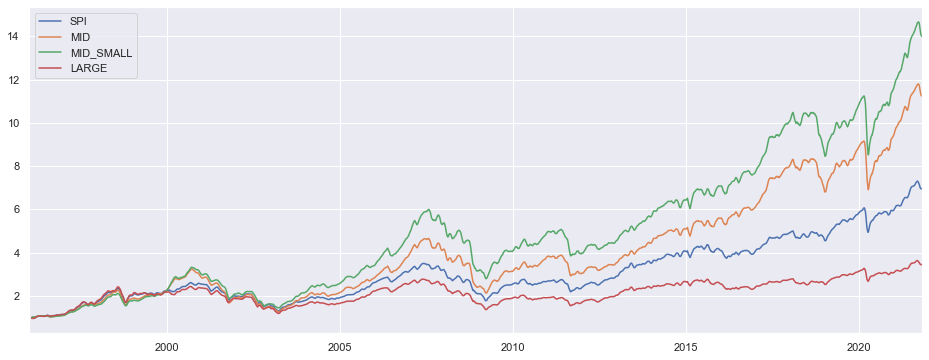

In [4]:
fig, ax = plt.subplots(figsize=(16,6))
(indices_price_excel.pct_change() + 1).cumprod().rolling(20).mean().plot(ax=ax)
plt.show()

In [5]:
mom12 = price.pct_change(periods=21 * 12)
mom6 = price.pct_change(periods=21 * 6)
mom1 = price.pct_change(periods=21 * 1)

ma200 = np.log(price / price.rolling(window=200).mean())
ma100 = np.log(price / price.rolling(window=100).mean())
ma50 = np.log(price / price.rolling(window=50).mean())

vol12 = price.rolling(window=21 * 12).std()
vol6 = price.rolling(window=21 * 6).std()
vol1 = price.rolling(window=21 * 1).std()

ema_12 = price.ewm(span=10).mean()
ema_26 = price.ewm(span=60).mean()
MACD = ema_12 - ema_26

RSI14 = RSI(price, 14)
RSI9 = RSI(price, 9)
RSI3 = RSI(price, 3)

df_dict = {}
df_X = pd.DataFrame()
for col in price.columns:
    df_temp = pd.concat([ma50[col], ma100[col], ma200[col],
                         mom12[col], mom6[col], mom1[col],
                         vol12[col], vol6[col], vol1[col],
                         RSI14[col], RSI9[col], RSI3[col], 
                         MACD[col]], axis=1).loc['1997-01-01':].fillna(method='ffill')
    df_temp.columns = ['ma50', 'ma100', 'ma200', 'mom12', 'mom6', 'mom1', 
                       'vol12', 'vol6', 'vol1', 'RSI14', 'RSI9', 'MACD', 'RSI3']
    df_dict[col] = df_temp
    
df_X = pd.concat(df_dict, axis=1)

In [6]:
def strategie(df_input_all, price, rebalance_freq, model_name='MLP', nb_epochs=50, nb_epochs_first=200, input_period=8, month_test_period=5, training_window=5, batch_size=1, verbose=0, threshold=0.4, eta=1e-3):
    
    first_end_date = '2002-02-01'
    num_tickers = len(df_input_all.columns.get_level_values(0).unique())
    num_features = len(df_input_all.columns.get_level_values(1).unique())
    
    returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
    best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc['1997-01-31':]
    
    prob_output = []
    pred_output = []
    
    if rebalance_freq == 'M':
        # The moving window every 6 month
        all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
    else:
        # The moving window every 26 weeks
        all_end_dates = best_pred.loc[first_end_date:].asfreq('W-FRI', method='ffill')[::26].index
    
    for i, end_date in enumerate(tqdm(all_end_dates)):

        start_date = end_date - relativedelta(years=training_window)
        
        # The first date input must before the first date output
        if rebalance_freq =='M':
            # Make sur the input period start the 1st of the month
            start_date_input = (start_date - relativedelta(weeks=input_period)).replace(day=1) 
        else:
            start_date_input = start_date - relativedelta(days=input_period)
            # Make sur the input period start a monday
            start_date_input = start_date_input - relativedelta(days=(start_date_input.weekday()))

        df_input = df_input_all.loc[start_date_input:end_date]
        df_output = best_pred.loc[start_date:end_date]

        X = []
        for idx in df_output.index:
            # If we rebalance monthly, the input data will be weekly data
            if rebalance_freq == 'M':
                df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
            # If we rebalance weekly, the input data will be daily data
            else:
                df_input_period = df_input.loc[:idx].iloc[-input_period:]
                
            X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
            X.append(X_period)

        X = np.array(X)
        y = df_output.values
        
        # Find the first prediction date
        if i == 0:
            if rebalance_freq == 'M':
                first_start_date_test = end_date - relativedelta(months=5)
            else:
                first_start_date_test = end_date - relativedelta(weeks=25)
        
        if rebalance_freq == 'M':
            start_date_test = (end_date - relativedelta(months=5))
            # Make sur the first test date is the end of the month
            year_test, month_test = start_date_test.year, start_date_test.month
            start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
            split_index = df_output.index.get_loc(start_date_test)    
        else:
            start_date_test = end_date - relativedelta(weeks=25)
            # Make sur the first test date is a friday
            delta_days = 4 - start_date_test.weekday()
            if delta_days < 0:
                delta_days += 7
            start_date_test = start_date_test + relativedelta(days=delta_days)
            split_index = df_output.index.get_loc(start_date_test)  
        
        # Create train and test set
        X_train, y_train = X[:split_index], y[:split_index]
        X_test, y_test = X[split_index:], y[split_index:]
        
        # Transform Numpy arrays to Torch tensors
        X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
        
        # Standardize data within each feature 
        train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
        train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
        X_train = X_train.sub_(train_mean).div_(train_std)
    
        test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
        test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
        X_test = X_test.sub_(test_mean).div_(test_std)
        
        # Allocate the tensors to the GPU, if there is one
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X_train = X_train.to(device)
        X_test = X_test.to(device)
        y_train = y_train.to(device)
        y_test = y_test.to(device)
        
        # Initialize ML models only at first iteration
        dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
        if i == 0:
            if model_name == 'MLP':
                model = MLP(dim1, dim2, dim3)
            elif model_name == 'ConvNet':
                model = ConvNet(dim1, dim2, dim3)
            elif model_name == 'LSTM':
                model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers)
        model.to(device)
        
        # More epochs needed for the first iteration 
        if i == 0:
            nb_epochs_all = nb_epochs_first
        else:
            nb_epochs_all = nb_epochs
        # Train the model
        train(model, X_train, y_train, X_test, y_test, nb_epochs_all, i, eta=eta, batch_size=batch_size, verbose=verbose)

        # Get predictions
        prob, pred = test(model, X_test, y_test, threshold=threshold)
        pred_output.append(pred)
        prob_output.append(prob)

    pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
    prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)
    
    return df_pred, df_prob

In [7]:
# models_list = ['MLP', 'ConvNet', 'LSTM']
models_list = ['MLP', 'ConvNet']
#models_list = ['ConvNet']
df_pred_dict = {}
df_prob_dict = {}

threshold = 0.8
batch_size = 10
verbose = 0
training_window = 5
nb_epochs_first = 5
nb_epochs = 1
rebalance_freq = 'W-FRI'
eta = 5e-3

if rebalance_freq == 'M':
    input_period = 8
else:
    input_period = 15

for i, model_name in enumerate(models_list):
    df_pred_dict[model_name], df_prob_dict[model_name] = strategie(df_input_all=df_X, price=price, rebalance_freq=rebalance_freq, 
                                                                   model_name=model_name, nb_epochs=nb_epochs, 
                                                                   nb_epochs_first=nb_epochs_first, input_period=input_period, 
                                                                   batch_size=batch_size, verbose=verbose, 
                                                                   training_window=training_window, threshold=threshold, eta=eta)
    
    if i == 0:
        df_prob_dict['Ensemble'] = df_prob_dict[model_name].copy()
    else:
        df_prob_dict['Ensemble'] += df_prob_dict[model_name]
        
df_prob_dict['Ensemble'] /= len(models_list)
#df_pred_dict['Ensemble'] = df_prob_ensemble.rank(axis=1).replace({1: 0., 2: 0., 3: 1.})

  0%|          | 0/40 [00:00<?, ?it/s]


TypeError: only integer tensors of a single element can be converted to an index

In [ ]:
df_pred_dict['Ensemble'] = pd.DataFrame().reindex_like(df_prob_dict['Ensemble']).fillna(0)
cols = df_pred_dict['Ensemble'].columns
for k in range(0, len(df_pred_dict['Ensemble'])):
    if k == 0:
        pred_index = df_prob_dict['Ensemble'].iloc[k].argmax()
        df_pred_dict['Ensemble'].iloc[k][cols[pred_index]] = 1
    else:
        out = df_prob_dict['Ensemble'].iloc[k].max()
        pred_index = df_prob_dict['Ensemble'].iloc[k].argmax()
        if out > threshold:
            df_pred_dict['Ensemble'].iloc[k][cols[pred_index]] = 1
        else:
            df_pred_dict['Ensemble'].iloc[k] = df_pred_dict['Ensemble'].iloc[k-1]

In [ ]:
perf_bench = price_to_perf(bench_price.loc[next(iter(df_pred_dict.items()))[1].index[0]:next(iter(df_pred_dict.items()))[1].index[-1]], log=False)
perf_bench_log = price_to_perf(bench_price.loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]], log=True)

In [ ]:
perf_bench = price_to_perf(bench_price.loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]], log=False)
perf_bench_log = price_to_perf(bench_price.loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]], log=True)

bench_stats = perf_to_stat(perf_bench, perf_bench)
stats = []
stats.append(bench_stats + [0])
for model_name in df_pred_dict:
    
    perf_gross = pred_to_perf(df_pred_dict[model_name], daily_returns, 0.)
    perf_net = pred_to_perf(df_pred_dict[model_name], daily_returns, 0.0012)
    
    turnover_num = turnover(df_pred_dict[model_name])
    stats.append(perf_to_stat(perf_gross, perf_net) + [turnover(df_pred_dict[model_name])])
stats = np.array(stats)

df_stats = pd.DataFrame(data=stats, columns=['Gross avg. annual return (%)', 'Net avg. annual return (%)', 
                                             'Avg. annual vol. (%)', 'Avg Sharpe ratio', 
                                             'Max. Drawdown (%)', 'Turnover'], 
                        index=['Benchmark SPI'] + list(df_pred_dict.keys())).round(2)

df_stats.Turnover = df_stats.Turnover.apply(int)
df_stats

In [ ]:
df = pd.DataFrame(index=models_list, columns=models_list)
for comb in itertools.product(models_list, repeat=2):
    model1 = comb[0]
    model2 = comb[1]
    df.loc[model1][model2] = correlation(df_pred_dict[model1], df_pred_dict[model2])
df = df.astype(float)
df.round(2)

In [ ]:
model_name = 'Ensemble'
performance_plot(df_pred_dict[model_name], model_name, daily_returns, bench_price)
annual_alpha_plot(perf_bench, df_pred_dict[model_name], model_name, daily_returns)
annual_alpha_plot_grossnet(perf_bench, df_pred_dict[model_name], model_name, daily_returns)

In [ ]:
df_results = pd.DataFrame()

for model_name in df_pred_dict:
    L = len(df_pred_dict[model_name])
    df_results = pd.concat([df_results, (df_pred_dict[model_name].sum(axis=0) / L).rename(model_name)], axis=1)
    
returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]]

df_results = pd.concat([df_results, (best_pred.sum(axis=0) / L).rename('Best_prediction')], axis=1)
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()

In [8]:
def last_month(date):
    year, month = date.year, date.month
    date_month = date.replace(day=calendar.monthrange(year, month)[1])
    return date_month

def last_friday(date):
    delta_days = 4 - date.weekday()
    if delta_days > 0:
        delta_days -= 7
    last_friday = date + relativedelta(days=delta_days)
    return last_friday

def next_friday(date):
    delta_days = 4 - date.weekday()
    if delta_days < 0:
        delta_days += 7
    last_friday = date + relativedelta(days=delta_days)
    return last_friday

In [15]:
nb_epochs = 20
model_name = 'MLP'
last_date = price.index[-1]
df_input_all = df_X
verbose = 3
last_date = price.index[-1]
rebalance_freq = 'M'

if rebalance_freq == 'M':
    last_date_train = last_month(last_date - relativedelta(weeks=input_period))
else:
    last_date_train = last_friday(last_date - relativedelta(days=input_period))

num_tickers = len(df_input_all.columns.get_level_values(0).unique())
num_features = len(df_input_all.columns.get_level_values(1).unique())

# Target data
returns = price[:last_date_train].pct_change().shift(1).resample(rebalance_freq, convention='end').agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1)

if rebalance_freq == 'M':
    start_date = last_month(last_date_train - relativedelta(years=training_window))
else:
    start_date = last_friday(last_date_train - relativedelta(years=training_window))

if rebalance_freq =='M':
    start_date_input = (start_date - relativedelta(weeks=input_period)).replace(day=1) 
else:
    start_date_input = start_date - relativedelta(days=input_period)
    start_date_input = start_date_input - relativedelta(days=(start_date_input.weekday()))

df_output = best_pred.loc[start_date:].dropna()
df_input = df_input_all.loc[start_date_input:df_output.index[-1]]

X = []
for idx in df_output.index:
    # If we rebalance monthly, the input data will be weekly data
    if rebalance_freq == 'M':
        dayofweek = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
        reb_freq_input = 'W-' + dayofweek[df_input_all.index[-1].weekday()][:3].upper()
        df_input_period = df_input.loc[:idx].asfreq(reb_freq_input, method='ffill').iloc[-input_period:]
    # If we rebalance weekly, the input data will be daily data
    else:
        df_input_period = df_input.loc[:idx].iloc[-input_period:]

    X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
    X.append(X_period)
    
X = np.array(X)
y = df_output.values
X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

train_mean = X.mean(dim=[0, 1, 2], keepdim=True)
train_std = X.std(dim=[0, 1, 2], keepdim=True)
X = X.sub_(train_mean).div_(train_std)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = X.to(device)
y = y.to(device)

# Initialize ML models only at first iteration
dim1, dim2, dim3 = X.size(1), X.size(2), X.size(3)
if model_name == 'MLP':
    model = MLP(dim1, dim2, dim3)
elif model_name == 'ConvNet':
    model = ConvNet(dim1, dim2, dim3)
elif model_name == 'LSTM':
    model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, device=device)
model.to(device)

train(model, X, y, nb_epochs, batch_size=batch_size, verbose=verbose)

# Today output
if rebalance_freq == 'M':
    dayofweek = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    reb_freq_input = 'W-' + dayofweek[df_input_all.index[-1].weekday()][:3].upper()
    df_input_period = df_input.loc[:idx].asfreq(reb_freq_input, method='ffill').iloc[-input_period:]
else:
    df_input_period = df_input_all.iloc[-input_period:]

X = df_input_period.values.reshape(input_period, num_tickers, num_features)
X = torch.from_numpy(X).float()
X = X.view(1, X.size(0), X.size(1), X.size(2))
out = model(X)
pd.DataFrame(index=[model_name], columns=price.columns, data=out.cpu().detach().numpy())

100%|██████████| 20/20 [00:00<00:00, 119.55it/s]


,MID,MID_SMALL,LARGE
MLP,0.0,1.0,0.0


In [19]:
print(X.device)

cpu


In [ ]:
pd.DataFrame(index=[model_name], columns=price.columns, data=out.cpu().detach().numpy()).round(2)

In [25]:
X.view(1, X.size(0), X.size(1), X.size(2)).shape

torch.Size([1, 15, 3, 13])

In [53]:
dayofweek = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

In [60]:
rebalance_freq = 'W-' + dayofweek[df_input_all.index[-1].weekday()][:3].upper()
rebalance_freq

'W-MON'

'MON'

In [49]:
df_input_all.tail()

MID                                                    \
                ma50     ma100     ma200     mom12      mom6      mom1   
2021-10-19 -0.010865 -0.003255  0.046336  0.364373  0.055551 -0.005763   
2021-10-20 -0.011174 -0.004238  0.044891  0.348953  0.061956 -0.008794   
2021-10-21 -0.014842 -0.008719  0.039965  0.316523  0.063277 -0.019731   
2021-10-22 -0.009917 -0.004513  0.043646  0.294141  0.073155 -0.023977   
2021-10-25 -0.009503 -0.004750  0.042944  0.279411  0.081867 -0.016111   

                                                                               \
                  vol12        vol6        vol1     RSI14      RSI9      MACD   
2021-10-19  1763.415156  824.248151  444.185562  0.651597  0.904409  0.696215   
2021-10-20  1745.074536  818.385550  434.900456  0.633956  0.859213  0.416472   
2021-10-21  1729.262127  810.733310  410.441631  0.638230  0.825493  0.260892   
2021-10-22  1716.872718  801.637353  364.243230  0.748370  0.839386  0.471777   
2021-10-25  1705.880548  789.602377  334.096435  0.713649  0.824452  0.510793   

                       MID_SMALL                                          \
                  RSI3      ma50     ma100     ma200     mom12      mom6   
2021-10-19 -224.948444 -0.009176  0.001592  0.055502  0.373455  0.069431   
2021-10-20 -184.308850 -0.009300  0.000786  0.054276  0.359322  0.075080   
2021-10-21 -165.842592 -0.011746 -0.002477  0.050613  0.330782  0.078644   
2021-10-22 -134.794971 -0.007792  0.000745  0.053351  0.308886  0.087038   
2021-10-25 -109.421697 -0.007483  0.000388  0.052565  0.294603  0.095227   

                                                                              \
                mom1       vol12        vol6        vol1     RSI14      RSI9   
2021-10-19 -0.007239  470.235091  229.016776  120.419415  0.648064  0.899257   
2021-10-20 -0.010779  466.112834  227.396342  117.330214  0.631035  0.862104   
2021-10-21 -0.019760  462.551104  225.239269  110.602425  0.645722  0.885130   
2021-10-22 -0.024860  459.760613  222.759630   98.002246  0.765614  0.888354   
2021-10-25 -0.015843  457.291264  219.563248   90.342343  0.735839  0.876199   

                                    LARGE                                \
                MACD       RSI3      ma50     ma100     ma200     mom12   
2021-10-19  0.805481 -47.785514 -0.010432 -0.006831  0.037149  0.225491   
2021-10-20  0.562500 -36.678980 -0.002858 -0.000257  0.043657  0.209005   
2021-10-21  0.368221 -30.267228  0.000489  0.002093  0.045925  0.187732   
2021-10-22  0.519305 -21.805664  0.002395  0.003003  0.046719  0.156434   
2021-10-25  0.552645 -14.979564  0.002919  0.002644  0.046201  0.156767   

                                                                              \
                mom6      mom1       vol12        vol6        vol1     RSI14   
2021-10-19  0.068818  0.013844  643.785813  412.355745  143.041905  0.763377   
2021-10-20  0.082926  0.018725  639.673546  407.241346  153.856850  0.788366   
2021-10-21  0.084861  0.017653  637.203302  402.214789  165.282782  0.887303   
2021-10-22  0.087948  0.010866  636.547953  396.787952  173.754718  0.888252   
2021-10-25  0.093404  0.021467  635.809707  390.226513  184.450754  0.887541   

                                           
                RSI9      MACD       RSI3  
2021-10-19  0.882697  0.647148 -74.253028  
2021-10-20  0.849334  0.690768 -47.413555  
2021-10-21  0.862084  0.737637 -20.897289  
2021-10-22  0.866020  1.000000   2.565790  
2021-10-25  0.892337  1.000000  21.118148

In [45]:
df_input_all.asfreq('W-MON').tail()

MID                                                    \
                ma50     ma100     ma200     mom12      mom6      mom1   
2021-09-27 -0.020225  0.004234  0.058268  0.281961  0.073433 -0.032613   
2021-10-04 -0.055883 -0.037427  0.015789  0.251644  0.020633 -0.073491   
2021-10-11 -0.043035 -0.030352  0.021527  0.271910  0.019155 -0.054350   
2021-10-18 -0.013024 -0.004701  0.045321  0.370407  0.053997 -0.024812   
2021-10-25 -0.009503 -0.004750  0.042944  0.279411  0.081867 -0.016111   

                                                                               \
                  vol12        vol6        vol1     RSI14      RSI9      MACD   
2021-09-27  1960.952792  897.502245  298.753869  0.301950  0.323440  0.275950   
2021-10-04  1921.243101  870.984003  579.483928  0.242529  0.239667  0.154225   
2021-10-11  1866.028780  850.520968  593.377733  0.346729  0.488144  0.811132   
2021-10-18  1782.991853  828.391690  449.740405  0.654243  0.746204  0.876136   
2021-10-25  1705.880548  789.602377  334.096435  0.713649  0.824452  0.510793   

                       MID_SMALL                                          \
                  RSI3      ma50     ma100     ma200     mom12      mom6   
2021-09-27   91.479206 -0.016340  0.011271  0.069059  0.291167  0.089484   
2021-10-04 -435.570214 -0.054724 -0.033124  0.024201  0.256051  0.033354   
2021-10-11 -567.834796 -0.042355 -0.026460  0.029587  0.278191  0.031594   
2021-10-18 -277.768356 -0.011402  0.000079  0.054389  0.380053  0.068245   
2021-10-25 -109.421697 -0.007483  0.000388  0.052565  0.294603  0.095227   

                                                                              \
                mom1       vol12        vol6        vol1     RSI14      RSI9   
2021-09-27 -0.028470  514.083340  252.170475   67.943005  0.320493  0.335957   
2021-10-04 -0.072655  505.683152  243.905046  147.050385  0.245789  0.222599   
2021-10-11 -0.053463  493.348855  236.992523  158.470063  0.334991  0.469728   
2021-10-18 -0.026459  474.635707  230.235654  122.246812  0.645226  0.753142   
2021-10-25 -0.015843  457.291264  219.563248   90.342343  0.735839  0.876199   

                                     LARGE                                \
                MACD        RSI3      ma50     ma100     ma200     mom12   
2021-09-27  0.267229   48.801421 -0.041420 -0.021176  0.023322  0.121693   
2021-10-04  0.166067  -93.950916 -0.045496 -0.030976  0.013236  0.134653   
2021-10-11  0.771852 -136.411669 -0.026959 -0.017747  0.026552  0.161898   
2021-10-18  0.921030  -61.931168 -0.007571 -0.002909  0.041126  0.233339   
2021-10-25  0.552645  -14.979564  0.002919  0.002644  0.046201  0.156767   

                                                                              \
                mom6      mom1       vol12        vol6        vol1     RSI14   
2021-09-27  0.052340 -0.058926  688.336822  466.033464  240.571690  0.216499   
2021-10-04  0.031597 -0.059337  681.486164  451.457811  248.224589  0.308830   
2021-10-11  0.045631 -0.022798  670.266776  435.245178  171.571834  0.489000   
2021-10-18  0.068290  0.003813  649.902438  416.599764  137.240919  0.863202   
2021-10-25  0.093404  0.021467  635.809707  390.226513  184.450754  0.887541   

                                            
                RSI9      MACD        RSI3  
2021-09-27  0.258744  0.271827 -159.961689  
2021-10-04  0.379546  0.291343 -274.657425  
2021-10-11  0.821455  1.000000 -221.276030  
2021-10-18  0.938996  1.000000  -91.841114  
2021-10-25  0.892337  1.000000   21.118148

In [156]:
df_input_all.resample('W', origin='end').last().tail()

MID                                                    \
                ma50     ma100     ma200     mom12      mom6      mom1   
2021-10-03 -0.046154 -0.026345  0.027127  0.239582  0.036566 -0.069266   
2021-10-10 -0.045061 -0.031138  0.021030  0.263408  0.027736 -0.058844   
2021-10-17 -0.011690 -0.002619  0.047812  0.378662  0.059064 -0.027583   
2021-10-24 -0.009917 -0.004513  0.043646  0.294141  0.073155 -0.023977   
2021-10-31 -0.009503 -0.004750  0.042944  0.279411  0.081867 -0.016111   

                                                                               \
                  vol12        vol6        vol1     RSI14      RSI9      MACD   
2021-10-03  1932.307756  874.170838  533.925325  0.277513  0.293200  0.518205   
2021-10-10  1878.791191  852.806861  599.205228  0.353402  0.309806  0.468768   
2021-10-17  1803.228928  832.558544  483.958842  0.497447  0.804408  1.000000   
2021-10-24  1716.872718  801.637353  364.243230  0.748370  0.839386  0.471777   
2021-10-31  1705.880548  789.602377  334.096435  0.713649  0.824452  0.510793   

                       MID_SMALL                                          \
                  RSI3      ma50     ma100     ma200     mom12      mom6   
2021-10-03 -339.181832 -0.043416 -0.020470  0.037046  0.247190  0.050912   
2021-10-10 -564.135986 -0.045691 -0.028587  0.027744  0.268140  0.038663   
2021-10-17 -334.708257 -0.010620  0.001609  0.056305  0.385491  0.071903   
2021-10-24 -134.794971 -0.007792  0.000745  0.053351  0.308886  0.087038   
2021-10-31 -109.421697 -0.007483  0.000388  0.052565  0.294603  0.095227   

                                                                              \
                mom1       vol12        vol6        vol1     RSI14      RSI9   
2021-10-03 -0.066875  508.133223  245.107454  133.565250  0.293774  0.285841   
2021-10-10 -0.059088  496.231100  237.893893  158.702442  0.338847  0.291076   
2021-10-17 -0.030463  479.235411  231.493336  131.533782  0.491195  0.798051   
2021-10-24 -0.024860  459.760613  222.759630   98.002246  0.765614  0.888354   
2021-10-31 -0.015843  457.291264  219.563248   90.342343  0.735839  0.876199   

                                     LARGE                                \
                MACD        RSI3      ma50     ma100     ma200     mom12   
2021-10-03  0.485404  -66.950678 -0.047148 -0.031531  0.012730  0.109102   
2021-10-10  0.454909 -134.868061 -0.027960 -0.017679  0.026616  0.161819   
2021-10-17  1.000000  -77.153408 -0.008856 -0.003195  0.040825  0.224931   
2021-10-24  0.519305  -21.805664  0.002395  0.003003  0.046719  0.156434   
2021-10-31  0.552645  -14.979564  0.002919  0.002644  0.046201  0.156767   

                                                                              \
                mom6      mom1       vol12        vol6        vol1     RSI14   
2021-10-03  0.033773 -0.065942  683.972576  453.755004  254.242840  0.313058   
2021-10-10  0.051304 -0.027312  673.092613  437.936445  181.357440  0.499350   
2021-10-17  0.064926 -0.003979  655.938537  420.072848  133.811888  0.662339   
2021-10-24  0.087948  0.010866  636.547953  396.787952  173.754718  0.888252   
2021-10-31  0.093404  0.021467  635.809707  390.226513  184.450754  0.887541   

                                            
                RSI9      MACD        RSI3  
2021-10-03  0.390705  0.716253 -263.838689  
2021-10-10  0.566429  0.928056 -240.264862  
2021-10-17  0.938192  1.000000 -121.227634  
2021-10-24  0.866020  1.000000    2.565790  
2021-10-31  0.892337  1.000000   21.118148

In [136]:
df_input_period

MID                                                    \
                ma50     ma100     ma200     mom12      mom6      mom1   
2021-09-27 -0.020225  0.004234  0.058268  0.281961  0.073433 -0.032613   
2021-09-28 -0.048351 -0.024845  0.029036  0.239854  0.043316 -0.065058   
2021-09-29 -0.045391 -0.023061  0.030724  0.234274  0.040427 -0.055320   
2021-09-30 -0.042017 -0.020928  0.032774  0.243537  0.048129 -0.059939   
2021-10-01 -0.046154 -0.026345  0.027127  0.239582  0.036566 -0.069266   
2021-10-04 -0.055883 -0.037427  0.015789  0.251644  0.020633 -0.073491   
2021-10-05 -0.045938 -0.028511  0.024460  0.255621  0.037959 -0.069386   
2021-10-06 -0.054726 -0.038544  0.014205  0.245504  0.025187 -0.077795   
2021-10-07 -0.043031 -0.027979  0.024509  0.251010  0.031677 -0.052483   
2021-10-08 -0.045061 -0.031138  0.021030  0.263408  0.027736 -0.058844   
2021-10-11 -0.043035 -0.030352  0.021527  0.271910  0.019155 -0.054350   
2021-10-12 -0.038618 -0.027017  0.024488  0.275839  0.022798 -0.050835   
2021-10-13 -0.024829 -0.014174  0.036967  0.317827  0.050284 -0.040364   
2021-10-14 -0.014263 -0.004480  0.046319  0.333381  0.060198 -0.022059   
2021-10-15 -0.011690 -0.002619  0.047812  0.378662  0.059064 -0.027583   

                                                                               \
                  vol12        vol6        vol1     RSI14      RSI9      MACD   
2021-09-27  1960.952792  897.502245  298.753869  0.301950  0.323440  0.275950   
2021-09-28  1953.656784  891.186446  399.926015  0.273120  0.262018  0.000000   
2021-09-29  1947.117031  885.843756  468.379040  0.262929  0.217606  0.052088   
2021-09-30  1940.067602  879.228331  506.103638  0.288679  0.251874  0.154739   
2021-10-01  1932.307756  874.170838  533.925325  0.277513  0.293200  0.518205   
2021-10-04  1921.243101  870.984003  579.483928  0.242529  0.239667  0.154225   
2021-10-05  1911.251777  865.273885  584.574578  0.312078  0.257436  0.373855   
2021-10-06  1900.307850  861.019531  595.063494  0.247413  0.157135  0.314757   
2021-10-07  1890.581797  856.732063  601.431868  0.314353  0.267783  0.678534   
2021-10-08  1878.791191  852.806861  599.205228  0.353402  0.309806  0.468768   
2021-10-11  1866.028780  850.520968  593.377733  0.346729  0.488144  0.811132   
2021-10-12  1853.271497  847.977396  577.283434  0.327841  0.499079  0.629863   
2021-10-13  1838.275044  842.393443  543.829583  0.350152  0.578474  1.000000   
2021-10-14  1823.468100  837.124479  522.409233  0.426502  0.678840  1.000000   
2021-10-15  1803.228928  832.558544  483.958842  0.497447  0.804408  1.000000   

                       MID_SMALL                                          \
                  RSI3      ma50     ma100     ma200     mom12      mom6   
2021-09-27   91.479206 -0.016340  0.011271  0.069059  0.291167  0.089484   
2021-09-28  -64.962989 -0.044563 -0.017901  0.039804  0.249124  0.058966   
2021-09-29 -180.056810 -0.042914 -0.017432  0.040246  0.241489  0.054358   
2021-09-30 -260.439212 -0.039121 -0.014889  0.042777  0.251942  0.062341   
2021-10-01 -339.181832 -0.043416 -0.020470  0.037046  0.247190  0.050912   
2021-10-04 -435.570214 -0.054724 -0.033124  0.024201  0.256051  0.033354   
2021-10-05 -477.737055 -0.045596 -0.025013  0.032092  0.258910  0.049853   
2021-10-06 -540.769311 -0.054142 -0.034799  0.022098  0.249807  0.037271   
2021-10-07 -550.317822 -0.042384 -0.024158  0.032497  0.257592  0.044588   
2021-10-08 -564.135986 -0.045691 -0.028587  0.027744  0.268140  0.038663   
2021-10-11 -567.834796 -0.042355 -0.026460  0.029587  0.278191  0.031594   
2021-10-12 -555.011739 -0.037698 -0.022872  0.032822  0.283243  0.036346   
2021-10-13 -496.272409 -0.023994 -0.010150  0.045211  0.324804  0.063278   
2021-10-14 -411.787053 -0.013441 -0.000499  0.054545  0.340932  0.072870   
2021-10-15 -334.708257 -0.010620  0.001609  0.056305  0.385491  0.071903   

                                                                              \
       

In [141]:
df_output.tail()

,MID,MID_SMALL,LARGE
2021-09-17,1.0,0.0,0.0
2021-09-24,0.0,0.0,1.0
2021-10-01,0.0,0.0,1.0
2021-10-08,0.0,1.0,0.0
2021-10-15,0.0,0.0,1.0


In [111]:
df_output.index[0].date().weekday()

4

In [73]:
price.pct_change().shift(1).resample('W-FRI').agg(lambda x: (x + 1).prod() - 1).tail()

,MID,MID_SMALL,LARGE
2021-10-01,-0.045322,-0.046930,-0.024119
2021-10-08,-0.004883,-0.006586,0.010204
2021-10-15,0.025617,0.026165,0.011054
2021-10-22,-0.002720,0.000098,0.012841
2021-10-29,0.004445,0.003581,0.001318


In [81]:
price.pct_change().shift(1).resample('W-FRI').last()

,MID,MID_SMALL,LARGE
1996-01-05,NaN,NaN,NaN
1996-01-12,-0.004544,-0.004707,-0.009261
1996-01-19,0.001842,0.000775,0.011959
1996-01-26,0.004903,0.003638,-0.003135
1996-02-02,0.009982,0.009101,0.009604
...,...,...,...
2021-10-01,0.002827,0.003377,0.001440
2021-10-08,0.011045,0.011203,0.016024
2021-10-15,0.010160,0.010211,0.006722
2021-10-22,-0.004239,-0.002891,0.002802


In [83]:
price.pct_change().shift(1).resample('W-FRI').first()

,MID,MID_SMALL,LARGE
1996-01-05,NaN,NaN,NaN
1996-01-12,0.002698,0.002599,-0.005801
1996-01-19,0.004584,0.005341,0.002680
1996-01-26,0.004283,0.004530,-0.001443
1996-02-02,-0.004589,-0.003157,-0.006166
...,...,...,...
2021-10-01,-0.007995,-0.009162,-0.010378
2021-10-08,-0.004887,-0.004905,-0.005741
2021-10-15,-0.002809,-0.004025,0.000060
2021-10-22,0.002229,0.002568,0.005664


In [21]:
input_period = 15
batch_size = 10
verbose = 0
training_window = 5
nb_epochs_first = 2
nb_epochs = 1
rebalance_freq = 'W-FRI'

model_name = 'MLP'

first_end_date = '2002-02-01'
num_tickers = len(df_input_all.columns.get_level_values(0).unique())
num_features = len(df_input_all.columns.get_level_values(1).unique())

returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc['1997-01-31':]

prob_output = []
pred_output = []

if rebalance_freq == 'M':
    # The moving window every 6 month
    all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
else:
    # The moving window every 26 weeks
    all_end_dates = best_pred.loc[first_end_date:].asfreq('W-FRI', method='ffill')[::26].index

for i, end_date in enumerate(tqdm(all_end_dates)):

    start_date = end_date - relativedelta(years=training_window)

    # The first date input must before the first date output
    if rebalance_freq =='M':
        # Make sur the input period start the 1st of the month
        start_date_input = (start_date - relativedelta(weeks=input_period)).replace(day=1) 
    else:
        start_date_input = start_date - relativedelta(days=input_period)
        # Make sur the input period start a monday
        start_date_input = start_date_input - relativedelta(days=(start_date_input.weekday()))

    df_input = df_input_all.loc[start_date_input:end_date]
    df_output = best_pred.loc[start_date:end_date]

    X = []
    for idx in df_output.index:
        # If we rebalance monthly, the input data will be weekly data
        if rebalance_freq == 'M':
            df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
        # If we rebalance weekly, the input data will be daily data
        else:
            df_input_period = df_input.loc[:idx].iloc[-input_period:]

        X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
        X.append(X_period)

    X = np.array(X)
    y = df_output.values

    # Find the first prediction date
    if i == 0:
        if rebalance_freq == 'M':
            first_start_date_test = end_date - relativedelta(months=5)
        else:
            first_start_date_test = end_date - relativedelta(weeks=25)

    if rebalance_freq == 'M':
        start_date_test = (end_date - relativedelta(months=5))
        # Make sur the first test date is the end of the month
        year_test, month_test = start_date_test.year, start_date_test.month
        start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
        split_index = df_output.index.get_loc(start_date_test)    
    else:
        start_date_test = end_date - relativedelta(weeks=25)
        # Make sur the first test date is a friday
        delta_days = 4 - start_date_test.weekday()
        if delta_days < 0:
            delta_days += 7
        start_date_test = start_date_test + relativedelta(days=delta_days)
        split_index = df_output.index.get_loc(start_date_test)  

    # Create train and test set
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]

    # Transform Numpy arrays to Torch tensors
    X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

    # Standardize data within each feature 
    train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
    train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
    X_train = X_train.sub_(train_mean).div_(train_std)

    test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
    test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
    X_test = X_test.sub_(test_mean).div_(test_std)


    # Initialize ML models only at first iteration
    dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
    if i == 0:
        if model_name == 'MLP':
            model = MLP(dim1, dim2, dim3)
        elif model_name == 'ConvNet':
            model = ConvNet(dim1, dim2, dim3)
        elif model_name == 'LSTM':
            model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, 
                         hidden_size=hidden_size, num_layers=num_layers)

    # More epochs needed for the first iteration 
    if i == 0:
        nb_epochs_all = nb_epochs_first
    else:
        nb_epochs_all = nb_epochs

    # Train the model
    train(model, X_train, y_train, X_test, y_test, nb_epochs_all, i, batch_size=batch_size, verbose=verbose)

    # Get predictions
    prob, pred = test(model, X_test, y_test)
    pred_output.append(pred)
    prob_output.append(prob)

pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)

return df_pred, df_prob

100%|██████████| 40/40 [00:04<00:00,  8.84it/s]
